# 시계열 탐색적 분석

## 일반적 EDA

<function matplotlib.pyplot.show(close=None, block=None)>

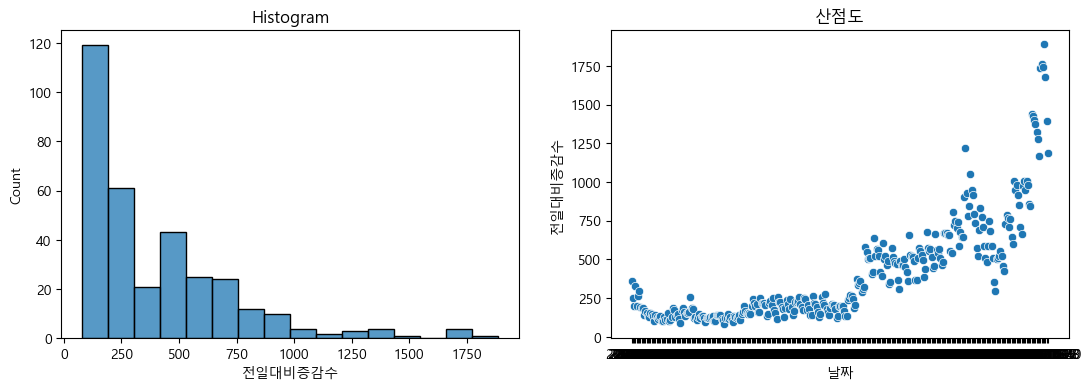

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import read_csv

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

ts = read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')
ts = ts.filter(['날짜', '전일대비증감수'])
ts = ts.set_index('날짜')
ts_head = ts.head(334)

fig, axes = plt.subplots(1, 2, figsize=(13,4))

axes[0].set_title('Histogram')
sns.histplot(x='전일대비증감수', data=ts_head, ax=axes[0])

axes[1].set_title('산점도')
sns.scatterplot(x='날짜', y='전일대비증감수', data=ts_head, ax=axes[1])
plt.show

## 시계열 특화 EDA

### 정상성 확인
- 정상성
    - 시간 흐름과 무관하게 평균과 분산이 일정하고 추세나 계절성을 갖지 않는다.
- 정상성 측도
    - ADF(Augmented Dickey-Fuller) 검정
        - 귀무가설('단위근이 있다')와 대립가설('단위근이 없다')로 검정.
        - 단위근이 없어야 정상성 만족 
    - KPSS(Kwiatowski-Philips-Schmidt-Shin) 검정
        - 귀무가설('정상 시계열이다')와 대립가설('비정상 시계열이다')로 검정.
        - 단위근이 없어야 정상성 만족 
    - ACF 그래프
        - 시차가 증가할수록 0으로 빠르게 감소
        - 비정상성 데이터는 느리게 감소
- 정상화 방법
    - 평균이 일정하지 않은 경우는 데이터를 차분(differencing)
    - 분산이 변환하는 경우는 데이터를 변환(transformation)
        - 로그 변환
        - 제곱근 변환
        - Box-cox 변환
        - Yeo-Johnson 변환

ADF Statistics: 0.762, p-value: 0.991
KPSS Statistics: 2.210, p-value: 0.010


C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2897145287.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ts_head, regression='c', nlags='auto')


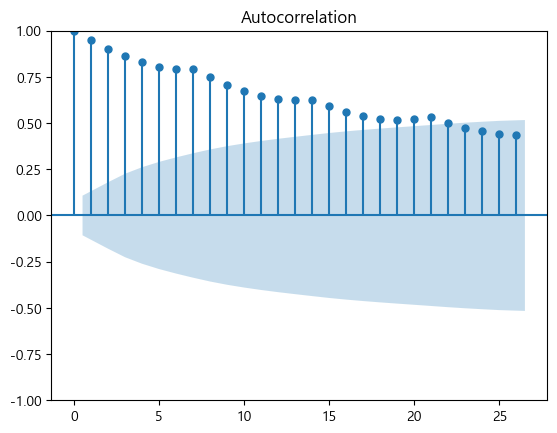

In [10]:
# ADF(Augmented Dickey-Fuller) 검정
#   귀무가설('단위근이 있다')와 대립가설('단위근이 없다')로 검정.
#       p-value가 0.05보다 작으면 대립가설, 단위근이 없다, 즉 정상 시계열로 본다.   
#   단위근이 없어야 정상성 만족 

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

result = adfuller(ts_head, regression='c', autolag='AIC')
print('ADF Statistics: {:.3f}, p-value: {:.3f}'.format(result[0], result[1]))


# KPSS(Kwiatowski-Philips-Schmidt-Shin) 검정
#   귀무가설('정상 시계열이다')와 대립가설('비정상 시계열이다')로 검정.
#       p-value가 0.05보다 작으면 대립가설, 즉 비정상 시계열로 본다.
#   단위근이 없어야 정상성 만족 
result = kpss(ts_head, regression='c', nlags='auto')
print('KPSS Statistics: {:.3f}, p-value: {:.3f}'.format(result[0], result[1]))


# ACF 그래프
#   값이 빠르게 떨어지면 정상성. 완만하게 떨어지면 비정상성
plot_acf(ts_head)
plt.show()

### 자기상관 확인
- 자기상관 (Autocorrelation)
    - 서로 다른 시점의 데이터 간 선형적 상관관계
- 자기상관 측도
    - 자기상관함수(Auto-correlation Funtion) 사용
        - x축은 시차, y축 자기상관계수
        - 임계치를 넘는다면 자기상관
    - 편자기상관함수 (Partial auto-correlation Function)
        - k 이외 모든 시점 관측치의 영향력을 배제하고 Yt와 Yt-k의 관련성 측정
    - 융-박스 검정
        - 귀무가설('자기상관이 없다')
    - 더빈왓슨 검정
        - 2에 가까울수록 자기상관 없고, 0에 가까울수록 자기상관

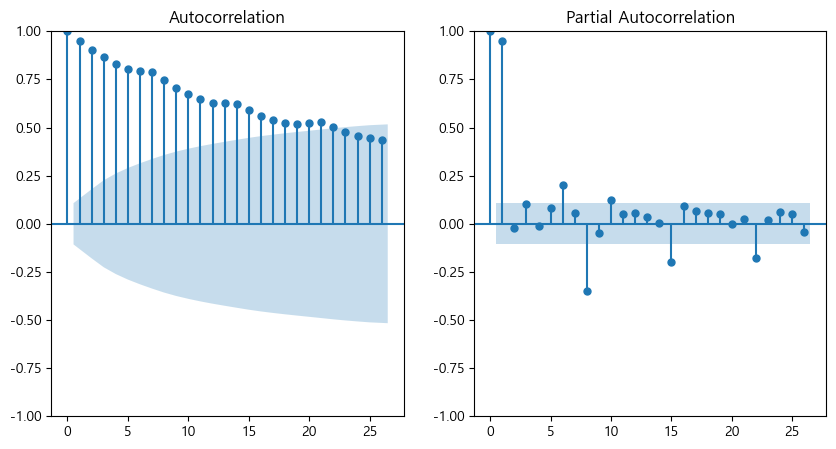

0시차: 자기상관계수 1.000, 신뢰구간 1.000 ~ 1.000
1시차: 자기상관계수 0.954, 신뢰구간 0.846 ~ 1.061
2시차: 자기상관계수 0.907, 신뢰구간 0.727 ~ 1.087
3시차: 자기상관계수 0.873, 신뢰구간 0.646 ~ 1.100


In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(ts_head, ax=axes[0])
plot_pacf(ts_head, ax=axes[1])
plt.show()

# ACF 그래프의 임계영역을 벗어나는 값들을 볼 때 자기상관이 있음을 파악
# PACF 그래프에서 lag 1, 3, 6, 8 등에서 자기상관을 암시하고 있음.

ACs, confs = acf(ts_head, fft=False, nlags=3, alpha=0.05, adjusted=True)
for lag, ac, conf in zip(range(3+1), ACs, confs):
    print(f'{lag}시차: 자기상관계수 {ac:.3f}, 신뢰구간 {conf[0]:.3f} ~ {conf[1]:.3f}')


### 시계열 분해
- 시계열 분해 시 요소
    - 추세 (trend variation)
    - 계절성 (seasonal variation)
    - 주기 (cycle variation)
    - 불규칙변동 (irregular variation)
- 시계열 분해 방법
    - 이동평균법
        - 불규칙변동과 계절변동 제거. 추세변동과 순환변동만 남김
    - 지수평활법
        - 불규칙변동 제거
        - 모든 데이터의 평균 활용. 최근 시계열에 가중치
    - STL 분해

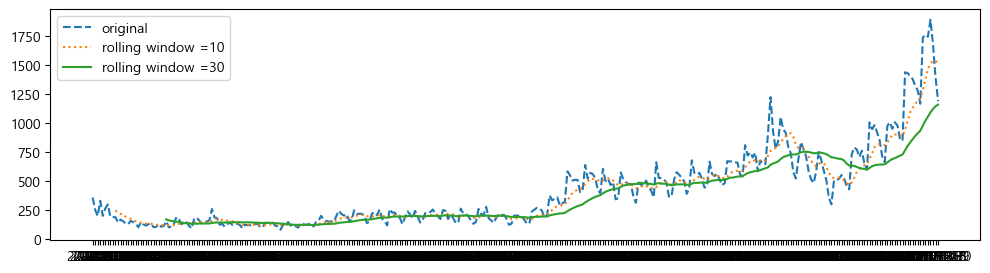

In [12]:
# 이동평균법 : 불규칙변동, 계절변동 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles=['original', 'rolling window =10', 'rolling window =30']
rw10 = ts_head.rolling(window=10).mean().dropna()
rw30 = ts_head.rolling(window=30).mean().dropna()
data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

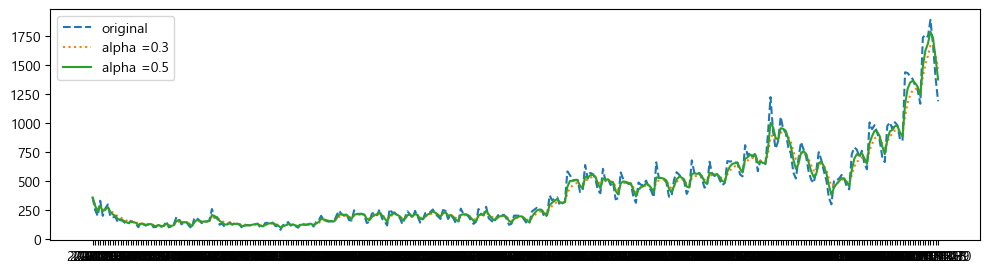

In [13]:
# 지수평활법 : 불규칙변동만 제거
fig, ax = plt.subplots(1,1, figsize=(12,3))

titles=['original', 'alpha =0.3', 'alpha =0.5']
ewm03 = ts_head.ewm(alpha=0.3).mean()
ewm05 = ts_head.ewm(alpha=0.5).mean()
data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()

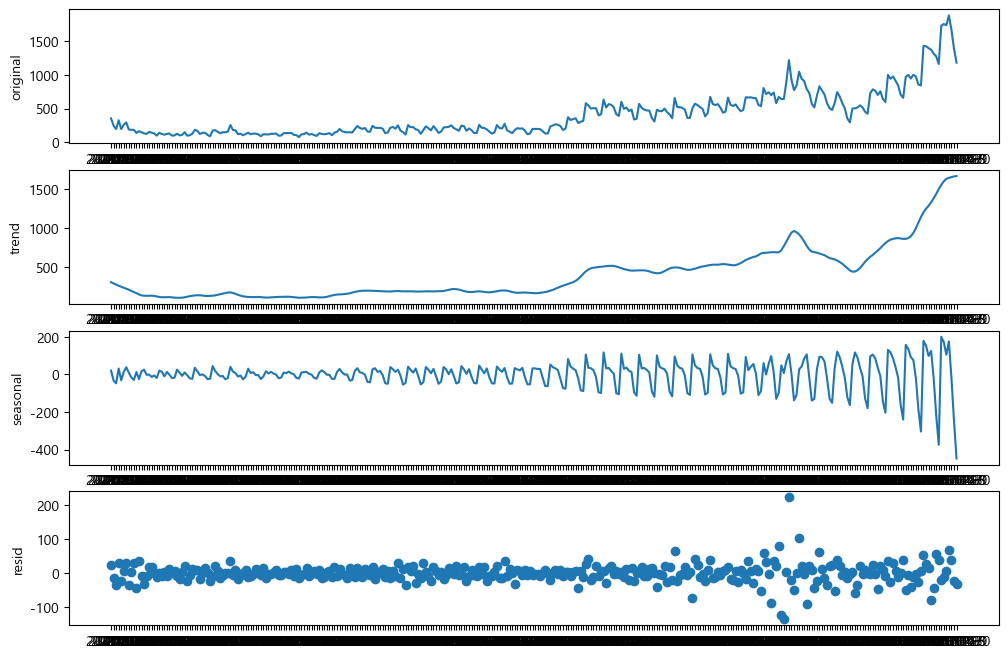

In [14]:
# STL분해

from statsmodels.tsa.seasonal import STL

# seasonal : Length of the seasonal smoother
# trend : Length of the trend smoother
fitted = STL(ts_head, seasonal=7, trend=9, period=7).fit()

resid = fitted.resid        # 잔차
seasonal = fitted.seasonal  # 추정된 계절요소
trend = fitted.trend        # 추정된 트렌드요소

titles=['original', 'trend', 'seasonal', 'resid']
data_list = [ts_head, trend, seasonal, resid]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
for title, data, ax in zip(titles, data_list, axes):
    ax.set_ylabel(title)
    if title != 'resid':
        ax.plot(data)
    else:
        ax.scatter(x=data.index, y=data.values)
plt.show()

# 시계열 데이터 전처리


- 시계열 데이터 전처리 유형
    - object, string, timestamp --> datetime 형식으로 변환 
    - 날짜/시간 데이터 생성
    - 날짜/시간 데이터 값 변경
    - 날짜/시간 데이터 연산
    - 날짜/시간 데이터에서 인덱스 추출하기

In [15]:
import time
import datetime as dt
import pandas as pd

ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')


# object -> datetime 변환
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')

In [17]:
# string - datetime 상호 변환 ===================================
string = '2018-09-13 22:39:04'

dtobj = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
print('string to datetime: ', type(dtobj))

string2 = dtobj.strftime('%Y-%m-%d %H:%M:%S')
print('datetime to string: ', type(string2))


# timestamp - datetime 변환 ===================================
timestamp = 2551780740
dtobj = dt.datetime.fromtimestamp(timestamp)
dtobj_utc = dt.datetime.utcfromtimestamp(timestamp)
timestamp2 = time.mktime(dtobj.timetuple())

print('timestamp to local datetime', dtobj)
print('timestamp to utc datetime', dtobj_utc)
print('timestamp from datetime', timestamp2)


# 날짜 데이터 생성하기 ===================================
dtobj1 = dt.datetime(2023, 3, 20, 11, 3, 3)
dtobj2 = dt.datetime.now()

date_only = dt.date(2023, 3, 20)
time_only = dt.time(11, 3, 3)
dtobj3 = dt.datetime.combine(date_only, time_only)

print(dtobj1, dtobj2, dtobj3)
print(date_only, time_only)


# 날짜 데이터 리스트 생성하기 ===================================

#freq = {A(연), M(월), D(일), T(분), S(초), Q(분기), W(주)}
datelist1 = pd.date_range('2016-01-01', periods=3, freq='D')
datelist2 = pd.date_range('2016-01-01', periods=4, freq='W')
datelist3 = pd.date_range('2016-01-01', '2016-01-02', freq='30T')
print('datetime 객체 : 1일 간격 3개 생성\n', datelist1)
print('datetime 객체 : 1주 간격 4개 생성\n', datelist2)
print('datetime 객체 : 30분 간격 기간 지정 생성\n', datelist3)

datelist4 = pd.period_range('2016-01-01', periods=2, freq='A')
datelist5 = pd.period_range('2016-01-01', periods=3, freq='Q')
print('period 객체 : 연단위 2개 생성\n', datelist4)
print('period 객체 : 분기단위 3개 생성\n', datelist5)


# 날짜/시간 간 연산하기 ===================================

week1 = dt.timedelta(weeks=1)
today = dt.datetime.now()

print('delta {}, type{}'.format(week1, type(week1)))
print('1주 전 날짜', today-week1)
print('1주 후 날짜', today+week1)


# 날짜/시간 열에서 특정 인덱스만 추출 ===================================
ts['년'] = ts.날짜.dt.year
ts['월'] = ts.날짜.dt.month
ts['일'] = ts.날짜.dt.day
ts['요일1'] = ts.날짜.dt.weekday
ts['요일2'] = ts.날짜.dt.day_name()


# Down sampling ===================================
#freq = {A(연), M(월), D(일), T(분), S(초), Q(분기), W(주)}

# 원하는 기간 별 대표 날짜의 데이터를 반환
print('분기 down sampling \n', ts.resample(rule='Q').asfreq())

# 원하는 기간 별 데이터의 합을 반환
print('\n\n분기별 데이터 합계 \n', ts.resample(rule='Q').sum())

# 원하는 기간 별 데이터의 평균 반환
print('\n\n분기별 데이터 평균 \n', ts.resample(rule='Q').mean())

string to datetime:  <class 'datetime.datetime'>
datetime to string:  <class 'str'>
timestamp to local datetime 2050-11-11 20:59:00
timestamp to utc datetime 2050-11-11 11:59:00
timestamp from datetime 2551780740.0
2023-03-20 11:03:03 2025-08-20 20:30:50.331364 2023-03-20 11:03:03
2023-03-20 11:03:03
datetime 객체 : 1일 간격 3개 생성
 DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D')
datetime 객체 : 1주 간격 4개 생성
 DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24'], dtype='datetime64[ns]', freq='W-SUN')
datetime 객체 : 30분 간격 기간 지정 생성
 DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00',
               '2016-01-01 01:00:00', '2016-01-01 01:30:00',
               '2016-01-01 02:00:00', '2016-01-01 02:30:00',
               '2016-01-01 03:00:00', '2016-01-01 03:30:00',
               '2016-01-01 04:00:00', '2016-01-01 04:30:00',
               '2016-01-01 05:00:00', '2016-01-01 05:30:00',
               '2016-01-01 06:00:00', '2016-0

C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1727242205.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datelist3 = pd.date_range('2016-01-01', '2016-01-02', freq='30T')
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1727242205.py:44: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  datelist4 = pd.period_range('2016-01-01', periods=2, freq='A')
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1727242205.py:72: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  print('분기 down sampling \n', ts.resample(rule='Q').asfreq())


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

- 시계열 데이터 결측치 처리
    - forward fill
        - 바로 이전 데이터로 채우기
    - backward fill
        - 바로 다음 데이터로 채우기
    - 이동평균 (Moving average)
        - 지난 데이터의 평균. 일종의 forward fill
        - 단순 산술평균 외에, 지수가중이동평균(exponentially weighted moving average)
    - 보간법 (Interpolation) : Pandas.interpolate
        - 선형보간법
        - 2차 스플라인(Quadratic spline) 보간법
        - 3차 스플라인(Cubic spline) 보간법
        - 다항식(polynomial) 보간법

In [ ]:
# 시계열 빈도 변경 (다운 샘플링)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')

ts.날짜 = ts.날짜.astype('datetime64[ns]')
ts = ts.set_index('날짜')
ts_na = ts.copy()

rand_numbers = np.random.randint(0, len(ts)-1, 50)
for num in rand_numbers:
    ts_na.iloc[num, :] = np.nan

ts_na.isna().sum()

누적확진자수     45
전일대비증감수    45
dtype: int64

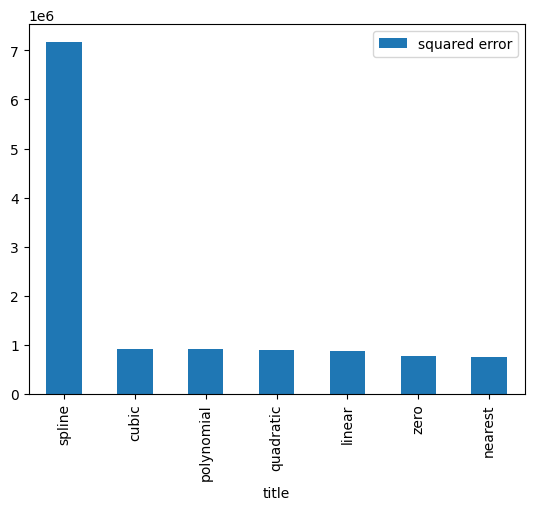

In [ ]:
#각종 보간 후, 실제 데이터와 비교
linear= ts_na.interpolate(method='linear')
nearest= ts_na.interpolate(method='nearest')
zero= ts_na.interpolate(method='zero')
quadratic= ts_na.interpolate(method='quadratic')    #'polynomial order=2와 동일
cubic= ts_na.interpolate(method='cubic')    #'polynomial order=3과 동일
spline= ts_na.interpolate(method='spline', order=2)
polynomial= ts_na.interpolate(method='polynomial', order=3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic', 'spline', 'polynomial']
datalist = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_err = []

for title, data in zip(titles, datalist):
    sqrd_e = sum((ts-data)['전일대비증감수']**2)
    sqrd_err.append(int(sqrd_e))

result = pd.DataFrame({'title':titles, 'error':sqrd_err}).sort_values(by='error', ascending=False)

result.plot.bar(x='title', y='error', label='squared error')
plt.show()

- 차분과 변환
    - 탐색적 분석 단계에서 시계열 데이터가 정상성을 갖지 않는 것으로 확인된 경우
    - 차분과 변환을 통해 데이터 전처리 필요

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ts = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv')

ts = ts.filter(['날짜', '전일대비증감수'])
ts.날짜 = ts.날짜.astype('datetime64[ns]')
ts = ts.set_index('날짜')

ts_head = ts.head(334)
ts_tail = ts.tail(31)

original: ADF p-value 0.991, KPSS p-value 0.010
diff(1): ADF p-value 0.004, KPSS p-value 0.100
diff(2): ADF p-value 0.005, KPSS p-value 0.100


C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\1193440112.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


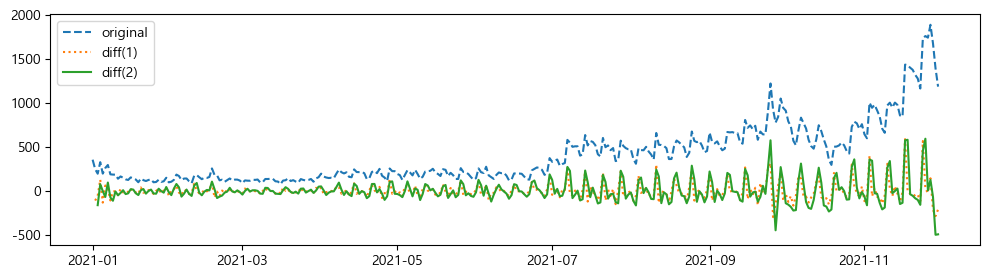

In [19]:
#차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
fig, ax = plt.subplots(1,1, figsize=(12, 3))

titles=['original', 'diff(1)', 'diff(2)']

diff1 = ts_head.diff(periods=1).dropna()
diff2 = ts_head.diff(periods=2).dropna()
datalist = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, datalist, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

# 1번의 차분으로 정상시계열이 되었다.

original: ADF p-value 0.991, KPSS p-value 0.010
log: ADF p-value 0.001, KPSS p-value 0.100
box-cox: ADF p-value 0.000, KPSS p-value 0.100


C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2744856793.py:27: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


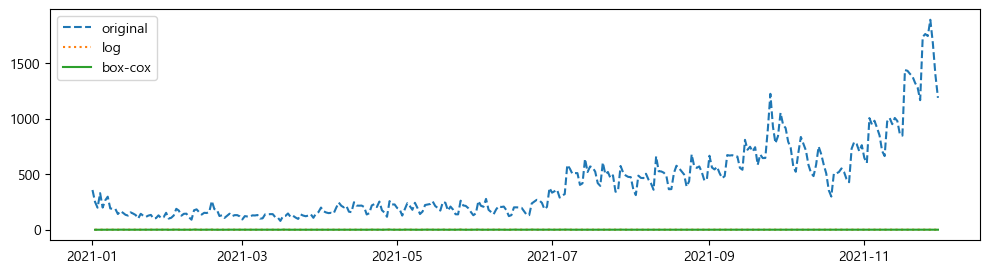

In [20]:
# 변환과 차분 전후 비교
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 로그변환
log = np.log(ts_head)

# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# 차분1회
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

# 시각화
titles = ['original','log','box-cox']
datalist = [ts_head, log, boxcox]
lslist = ['dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1,1, figsize=(12, 3))
for title, data, ls in zip(titles, datalist, lslist):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

log: ADF p-value 0.001, KPSS p-value 0.100
box-cox: ADF p-value 0.000, KPSS p-value 0.100


C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2815488205.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_32128\2815488205.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


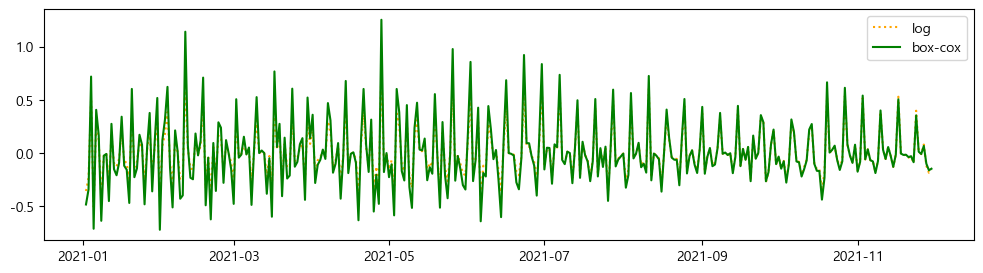

In [21]:
titles = ['log','box-cox']
datalist = [log, boxcox]
lslist, clist = ['dotted', 'solid'], ['orange', 'green']
fig, ax = plt.subplots(1,1, figsize=(12, 3))
for title, data, ls, c in zip(titles, datalist, lslist, clist):
    ax.plot(data, label=title, linestyle=ls, color=c)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

# 시계열 모델링 및 평가

### 개념
- 자기회귀 (AR, Auto Regressive) 모델
    - n번째 데이터는 1~n-1번 데이터에 가중치를 곱함으로써 구할 수 있다.
- 이동평균 (MA, Moving Average) 모델
    - n번째 데이터는 1~n-1번의 오차항에 가중치를 곱합으로써 구할 수 있다.
    - MA(1)이면 현재 오차항에 직전 오차항 사용
- 자기회귀 이동평균 (ARMA, Auto Regressive Moving Average) 모델 
    - AR(p)모델과 MA(q)모델을 더한 것
- 자기회귀 누적 이동평균 (ARIMA, Auto Regressive Integrated Moving Average) 모델 
    - d회 차분 후 AR(p)모델과 MA(q)모델을 더한 것
    - ARIMA(p, d, q)로 표현함.
- 계절성 ARIMA 모델

### Box-Jenkins와 ARIMA
- 정상성과 계절성 확인
- 정상성을 위한 차분과 변환 진행
- 적절한 차수 p와 q찾기 (ACF / PACF 그래프 활용)
    - AR(p)는 ACF 값이 천천히 감소, PACF값은 p 이후에 빠르게 감소
        - AR(p)는 PACF에서 마지막으로 절단선에 걸린 lag로 정한다.
    - MA(q)는 ACF 값이 q이후 빠르게 감소, PACF에서 천천히 감소
        - MA(q)는 ACF에서 마지막으로 절단선에 걸린 lag으로 정한다.
- 모델 검정에는 잔차의 정상성(Ljung-Box), 등분산성(Heteroskedasticity), 정규성(JB) 검정을 포함한다.
    - 정상성. Ljung-Box (Q), 
        - 귀무가설 : 잔차가 백색잡음이다. 즉 p-value는 0.05보다 커야 함.
    - 등분산성. Heteroskedasticity (H), 
        - 귀무가설 : 잔차가 등분산성을 갖는다. 즉 p-value는 0.05보다 커야 함.
    - 정규성. Jarque-Bera (JB)
        - 귀무가설 : 정규성을 만족한다. 즉 p-value는 0.05보다 커야 함.

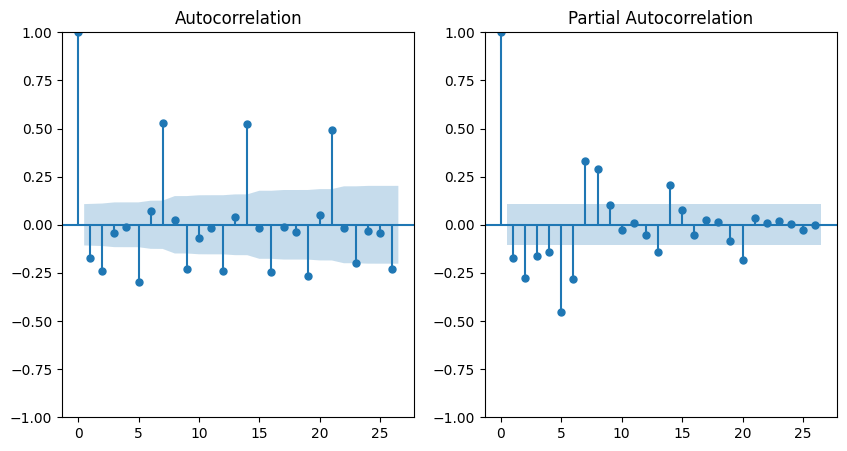

In [13]:
# Box-Jenkins 방법
#   boxcox 변환 및 차분을 통해 정상화
#   boxcox로 적절한 차수 찾기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
import numpy as np

# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# 차분1회
boxcox = boxcox.diff(1).dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(boxcox, ax=ax[0])
plot_pacf(boxcox, ax=ax[1])
plt.show()

## 차수는 plot 상의 절단선을 참고하여 p=9, q=2로 정하여 모델을 적합하기로 한다.

# 모델의 계절성
p = 9   #AR 차수
d = 1   #차분 회수
q = 2   #MA 차수

# 모델의 비계절성
P = 0
D = 0
Q = 1   # PACF가 지수적으로 감소할 때 1로 설정
s = 7   # ACF에서 lag7마다 뾰족한 막대. 계절성 단위는 7이 된다.

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA에서 seasonal_order를 입력하면 SARIMAX와 동일한 결과
model = ARIMA(ts_head, order=(p,d,q), seasonal_order=(P,D,Q,s))
fitted = model.fit()
resid = fitted.resid

# pred1과 pred2는 동일한 값임
pred1 = fitted.forecast(31) #이후 31개 날짜의 값을 예측
pred2 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) #시작/종료 날짜로 예측측

fitted.summary()

# 잔차의 정규성 : Jarque-Bera 검정을 통해 귀무가설 채택하면 정규성 인정 --> prob 값이 0.00으로 귀무가설 지지할 수 없다.
# 잔차의 자기상관 : Ljung-Box 검정을 통해 귀무가설 채택하면 자기상관 없음 인정 --> prob 값이 0.00으로 귀무가설 지지할 수 없다.

# ACF/PACF 관찰을 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선 필요요
# 결과 상 잔차 검정 시 정규성과 등분산성이 만족되지 않는다. 모델 개선이 필요하다.

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.018
Date:                           Wed, 20 Aug 2025   AIC                           3734.037
Time:                                   21:37:44   BIC                           3783.543
Sample:                               01-01-2021   HQIC                          3753.778
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0281      0.999     -0.028      0.978      -1.987       1.930
ar.L2         -0.1718      0.495     -0.347      0.729      -1.142       0.799
ar.L3         -0.0261      0.029     -0.913      0.361      -0.082       0.030
ar.L4         -0.0402      0.038     -1.069      0.285      -0.114       0.033
ar.L5         -0.0381      0.033     -1.154      0.249      -0.103       0.027
ar.L6         -0.0319      0.031     -1.023      0.306      -0.093       0.029
ar.L7          0.9457      0.040     23.478      0.000       0.867       1.025
ar.L8          0.0045      0.972      0.005      0.996      -1.900       1.909
ar.L9          0.1372      0.475      0.289      0.772      -0.793       1.067
ma.L1         -0.2069      0.993     -0.208      0.835      -2.152       1.738
ma.L2          0.0489      0.704      0.069      0.945      -1.332       1.430
ma.S.L7       -0.6528      0.059    -11.156      0.000      -0.768      -0.538
sigma2      4656.9424    268.174     17.365      0.000    4131.330    5182.555
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1187.00
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 자동 차수 선택방법과 ARIMA
- 여러 조합의 차수들을 적용하여 적합한 모델을 찾는다.
    - 적합성의 판단 기준은 가능도는 가장 높고 AIC값는 가장 낮은 것.
    - pmdarima 패키지의 auto_arima 사용하거나 반복문 코딩

In [ ]:
#자동 차수 선택방법 1. auto_arima
import numpy as np
import pandas as pd
from pmdarima import auto_arima

# numpy 라이브러리를 2.0 미만으로 설치하고 vs code 재시작해야 함.
# pip install "numpy<2.0.0" --force-reinstall

auto_arima(ts_head, 
           start_p=1,
           start_q=1,
           max_p=5,
           max_q=5,
           start_P=0,
           start_Q=0,
           max_P=5,
           max_Q=5,
           m=7,seasonal=True,
           trace=False,
           error_action='warn',
           suppress_warnings=True)

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ut

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_head, order=(3,1,0), seasonal_order=(1,0,1,7))
fitted = model.fit()
resid = fitted.resid
pred3 = fitted.forecast(31)
pred4 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

fitted.summary()

# 잔차의 정규성 : Jarque-Bera 검정을 통해 귀무가설 채택하면 정규성 인정 --> prob 값이 0.00으로 귀무가설을 기각한다.
# 잔차의 자기상관 : Ljung-Box 검정을 통해 귀무가설 채택하면 자기상관 없음 인정 --> prob 값이 0.93으로 귀무가설 기각할 수 없다.

# 결과상 여전히 정규성을 만족하지 않는다.

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Wed, 20 Aug 2025   AIC                           3717.507
Time:                                   20:41:59   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2261      0.036     -6.295      0.000      -0.297      -0.156
ar.L2         -0.1732      0.039     -4.399      0.000      -0.250      -0.096
ar.L3         -0.1134      0.042     -2.692      0.007      -0.196      -0.031
ar.S.L7        0.9825      0.015     66.311      0.000       0.953       1.012
ma.S.L7       -0.6567      0.040    -16.420      0.000      -0.735      -0.578
sigma2      3829.7007    168.144     22.776      0.000    3500.145    4159.256
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               918.40
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
#자동 차수 선택방법 2. 반복문 사용
import itertools

p = range(0, 4)
d = range(1, 2)
q = range(0, 3)

Q = D = P = range(0, 2)
m = [4, 7, 12]
combis = list(itertools.product(p, d, q, P, D, Q, m))

dict_model={}
for i, combi in enumerate(combis):
    try:
        no_seasonal = combi[:3]
        seasonal = combi[3:]
        model = ARIMA(ts_head, order=(no_seasonal), seasonal_order=(seasonal))
        fitted = model.fit()
        dict_model[combi]=[fitted.llf, fitted.aic]  # llf는 높을수록, aic는 낮을수록 좋음
    except:
        print('except: ', i, combi) # LU decomposition error 발생하는 경우 pass
        continue

result = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'AIC']).sort_values(by='AIC', ascending=True)
print(result)

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\

                               llf          AIC
(1, 1, 0, 1, 0, 1, 7)     0.000000     8.000000
(3, 1, 1, 0, 1, 1, 7) -1807.948928  3627.897856
(3, 1, 2, 0, 1, 1, 7) -1807.943639  3629.887279
(3, 1, 0, 0, 1, 1, 7) -1810.092109  3630.184218
(0, 1, 2, 0, 1, 1, 7) -1811.281482  3630.562964
...                            ...          ...
(3, 1, 0, 0, 1, 0, 4) -2067.112994  4142.225988
(2, 1, 0, 0, 1, 0, 4) -2086.585068  4179.170136
(0, 1, 1, 0, 1, 0, 4) -2088.194196  4180.388392
(1, 1, 0, 0, 1, 0, 4) -2088.409186  4180.818373
(0, 1, 0, 0, 1, 0, 4) -2089.657718  4181.315436

[288 rows x 2 columns]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ts_head, order=(3,1,1), seasonal_order=(0,1,1,7))
fitted = model.fit()

resid = fitted.resid
pred5 = fitted.forecast(31)
pred6 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

print(fitted.summary())

# 잔차의 정규성 : Jarque-Bera 검정을 통해 귀무가설 채택하면 정규성 인정 --> prob 값이 0.00으로 귀무가설을 기각한다.
# 잔차의 자기상관 : Ljung-Box 검정을 통해 귀무가설 채택하면 자기상관 없음 인정 --> prob 값이 0.93으로 귀무가설 기각할 수 없다.

# 결과상 여전히 정규성을 만족하지 않는다.

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                         전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1807.949
Date:                         Wed, 20 Aug 2025   AIC                           3627.898
Time:                                 20:57:51   BIC                           3650.619
Sample:                             01-01-2021   HQIC                          3636.965
                                  - 11-30-2021                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9659      0.108     -8.966      0.000      -1.177      -0.755
ar.L2         -0.3312      0.046     -7.160      0.000     

In [16]:
from sklearn.metrics import r2_score

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mape

titles = ['box-jenkins', 'auto_arima', 'for_loop']
ts_tail1d = ts_tail.values.ravel()
preds = [pred1.values, pred3.values, pred5.values]

for title, pred in zip(titles, preds):
    r2 = r2_score(ts_tail1d, pred)
    mape = MAPE(ts_tail1d, pred)
    print('{}: R2 {:.3f}, MAPE {:.3f}'.format(title, r2, mape))
    

# for_loop 방식이 가낭 낮은 오차율 MAPE, 비교적 높은 설명력 R2를 가진 것으로 나타남


box-jenkins: R2 -1.519, MAPE 26.662
auto_arima: R2 -0.740, MAPE 24.503
for_loop: R2 -0.667, MAPE 24.447


# 연습문제

### 1.
- Microsoft 주식 가격데이터. 
- 주 단위 평균 가격으로 다운샘플링하라.
- 앞의 데이터 300개를 down_head, 뒤의 데이터 14개를 down_tail로 분할하시오.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.unicode_minus'] = False

ms = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/practice12_ms_stock.csv', encoding='euc-kr')
ms.Date = ms.Date.astype('datetime64[ns]')
ms = ms.set_index('Date')

ms.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1511 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [2]:
ms_w = ms.dropna().resample(rule='W').mean()

temp = ms_w.head(314)
down_head = temp.head(300)
down_tail = temp.tail(14)


### 2.
- down_head 데이터로 탐색적 분석을 진행하시오.

ADF Statistics: 2.240, p-value: 0.999
KPSS Statistics: 2.593, p-value: 0.010
융-박스 테스트
      lb_stat      lb_pvalue
1  294.753777   4.579097e-66
2  582.583051  3.116721e-127
3  863.943057  5.859132e-187
더빈-왓슨 계수
[0.00083511]


C:\Users\krkim1\AppData\Local\Temp\ipykernel_36144\725860741.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(down_head, regression='c', nlags='auto')


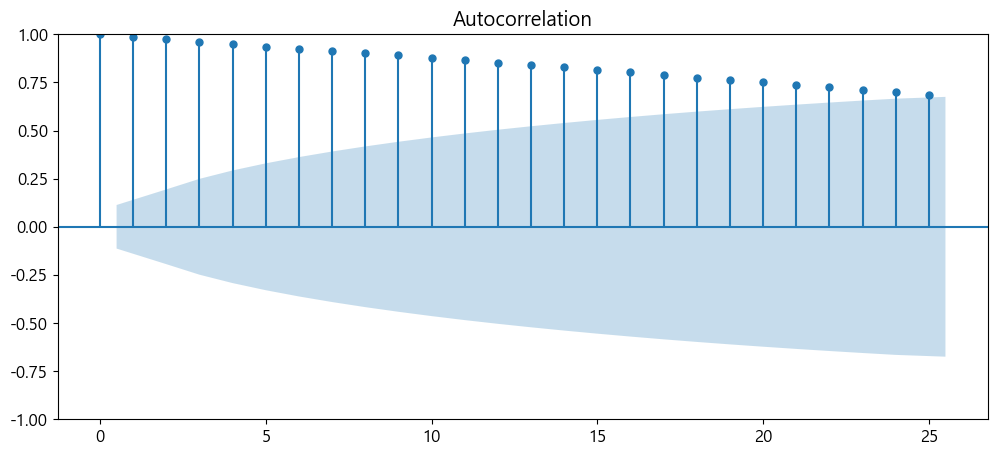

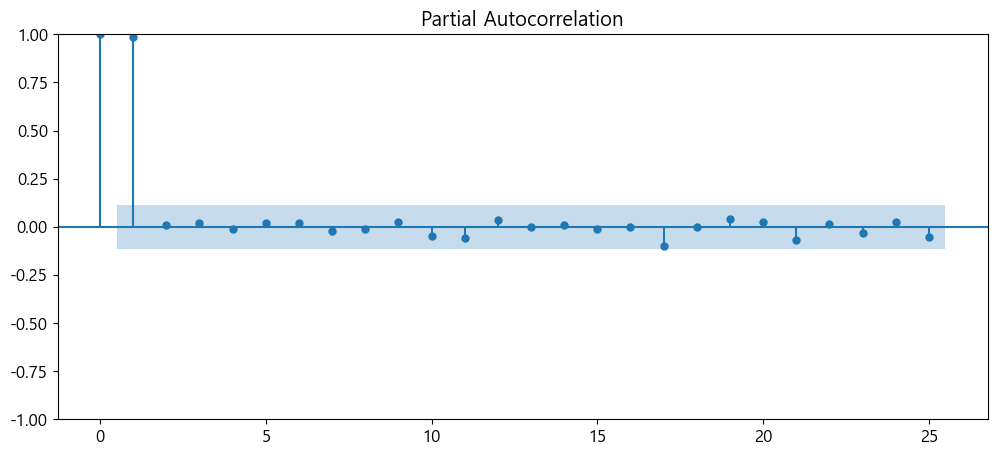

In [ ]:
# ----------------------------------------------------------------
# 정상성 및 자기상관성 가정 확인
# ----------------------------------------------------------------

# 정상성 확인
    # ADF 검정  : [귀무가설] 단위근이 있다 / [대립가설] 단위근이 없다 -> 정상시계열
    # KPSS 검정 : [귀무가설] 정상시계열이다 / [대립가설] 정상시계열이 아니다.
    # ACF검정 : 시차가 증가할수록 자기상관계수가 빨리 0으로 떨어져야 한다. 정상시계열이 아니라면 천천히 떨어진다.

from statsmodels.tsa.stattools import adfuller, kpss

result_adf = adfuller(down_head, regression='c', autolag='AIC')
print('ADF Statistics: {:.3f}, p-value: {:.3f}'.format(result_adf[0], result_adf[1]))
# 검정 결과 귀무가설을 기각할 수 없다. 즉 정상시계열이 아니다.

result_kpss = kpss(down_head, regression='c', nlags='auto')
print('KPSS Statistics: {:.3f}, p-value: {:.3f}'.format(result_kpss[0], result_kpss[1]))
# 검정 결과 귀무가설은 지지되지 않는다. 즉 정상시계열이 아니다.


# 자기상관성 확인 확인
    # 융-박스 테스트    : [귀무가설] 상관관계를 갖지 않는다. / [대립가설] 상관관계를 갖는다.
    # 더빈-왓슨 검정    : 2에 가까우면 자기 상관이 없다. / 0으로 가까워지고, 4로 가까워지면 자기상관이 있다.
    # PACF : 시차가 증가할수록 자기상관계수가 빨리 0으로 떨어져야 한다. 정상시계열이 아니라면 천천히 떨어진다.

from statsmodels.stats.diagnostic import acorr_ljungbox
result_ljung = acorr_ljungbox(down_head, return_df=True, auto_lag=True).head(3)
print('융-박스 테스트')
print(result_ljung)
# p-value를 볼 때 자기상관성을 갖는다.

from statsmodels.stats.stattools import durbin_watson
result_durb = durbin_watson(down_head)
print('더빈-왓슨 계수')
print(result_durb)
# 0에 가까워져 자기상관성을 갖는다.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(down_head)
plot_pacf(down_head)
plt.show()

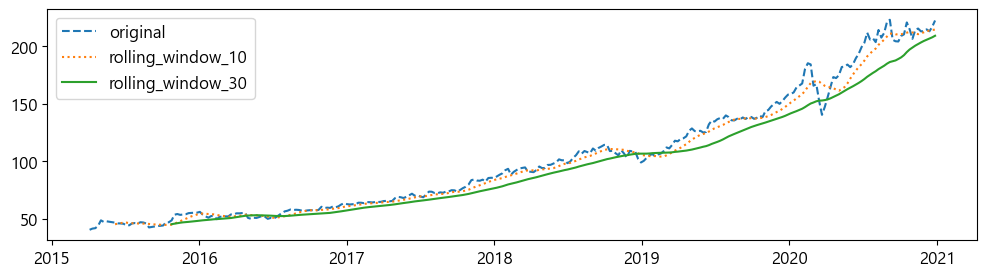

In [4]:
# ----------------------------------------------------------------
# 데이터 플로팅
# ----------------------------------------------------------------

# 기본 데이터 플로팅
rw10 = down_head.rolling(window=10).mean()
rw30 = down_head.rolling(window=30).mean()

fig, ax = plt.subplots(1,1, figsize=(12, 3))
data_list = [down_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']
titles = ['original', 'rolling_window_10', 'rolling_window_30']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
plt.legend()
plt.show()



original: ADF p-value 0.999, KPSS p-value 0.010
diff-1: ADF p-value 0.000, KPSS p-value 0.100
diff-2: ADF p-value 0.000, KPSS p-value 0.087


C:\Users\krkim1\AppData\Local\Temp\ipykernel_36144\2508231605.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_36144\2508231605.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


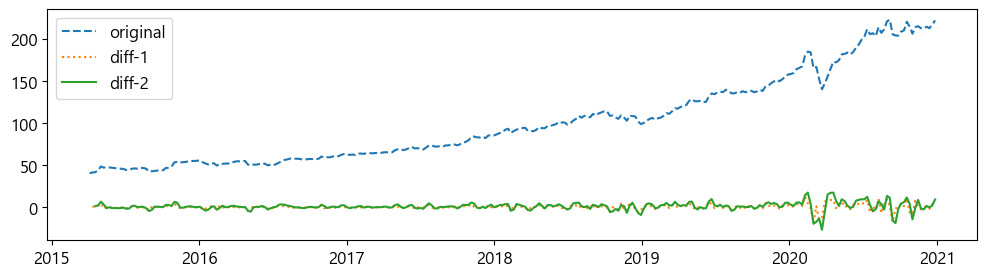

In [5]:
# ----------------------------------------------------------------
# 정상화 처리
# ----------------------------------------------------------------

# 차분 적용
diff1 = down_head.diff(periods=1).dropna()
diff2 = down_head.diff(periods=2).dropna()

fig, ax = plt.subplots(1,1, figsize=(12, 3))
titles = ['original', 'diff-1', 'diff-2'] 
data_list =[down_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()

diff-1: ADF p-value 0.000, KPSS p-value 0.100
box-cox + diff-1: ADF p-value 0.000, KPSS p-value 0.100


C:\Users\krkim1\AppData\Local\Temp\ipykernel_36144\2035022300.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]
C:\Users\krkim1\AppData\Local\Temp\ipykernel_36144\2035022300.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(data)[1]


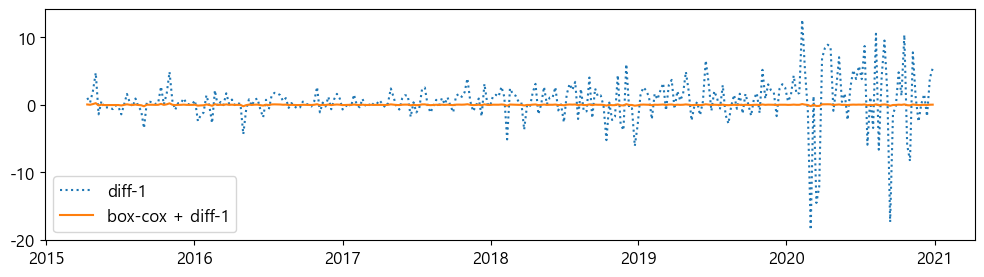

In [6]:
# 변환 적용
from sklearn.preprocessing import PowerTransformer

# box-cox 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(down_head)
boxcox = pd.DataFrame(rescaled, index=down_head.index, columns=down_head.columns)

# 차분 적용
boxcox = boxcox.diff(1).dropna()

fig, ax = plt.subplots(1,1, figsize=(12, 3))
titles = ['diff-1', 'box-cox + diff-1'] 
data_list =[diff1, boxcox]
ls_list = ['dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
    ax.plot(data, label=title, linestyle=ls)
    ap = adfuller(data)[1]
    kp = kpss(data)[1]
    print('{}: ADF p-value {:.3f}, KPSS p-value {:.3f}'.format(title, ap, kp))
plt.legend()
plt.show()


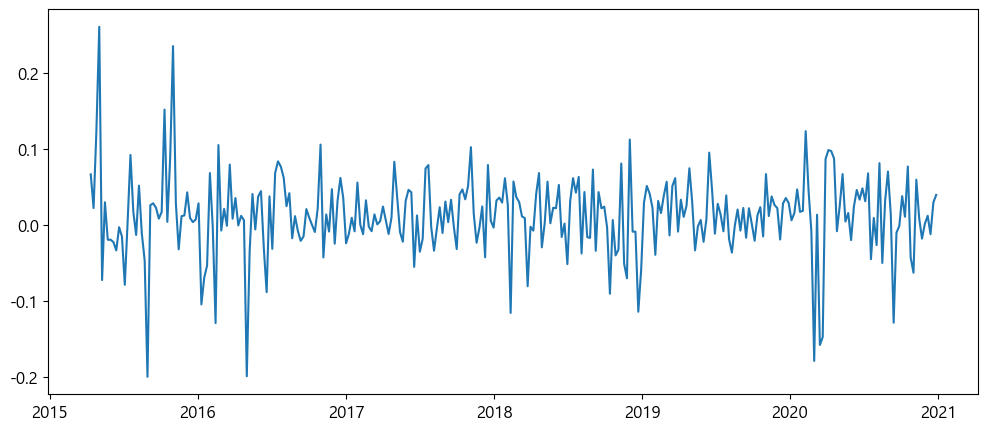

In [7]:
plt.plot(boxcox, label='box-cox + diff-1', linestyle='solid')

### 3.
- down_head 데이터로 시계열모델을 적합하시오

In [10]:
import itertools

p = range(0, 4)
d = range(1, 2)
q = range(0, 3)

Q=D=P=range(0, 2)
m = [4, 7, 12]

combis = list(itertools.product(p, d, q, P, D, Q, m))

dict_model = {}
for i, combi in enumerate(combis):
    try:
        model =ARIMA(down_head, order=combi)
        fitted = model.fit()
        dict_model[combi] = [fitted.llf, fitted.aic]
    except:
        print('except: ', i, combi)
        continue

result = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'AIC']).sort_values(by='AIC', ascending=True)
print(result)

except:  0 (0, 1, 0, 0, 0, 0, 4)
except:  1 (0, 1, 0, 0, 0, 0, 7)
except:  2 (0, 1, 0, 0, 0, 0, 12)
except:  3 (0, 1, 0, 0, 0, 1, 4)
except:  4 (0, 1, 0, 0, 0, 1, 7)
except:  5 (0, 1, 0, 0, 0, 1, 12)
except:  6 (0, 1, 0, 0, 1, 0, 4)
except:  7 (0, 1, 0, 0, 1, 0, 7)
except:  8 (0, 1, 0, 0, 1, 0, 12)
except:  9 (0, 1, 0, 0, 1, 1, 4)
except:  10 (0, 1, 0, 0, 1, 1, 7)
except:  11 (0, 1, 0, 0, 1, 1, 12)
except:  12 (0, 1, 0, 1, 0, 0, 4)
except:  13 (0, 1, 0, 1, 0, 0, 7)
except:  14 (0, 1, 0, 1, 0, 0, 12)
except:  15 (0, 1, 0, 1, 0, 1, 4)
except:  16 (0, 1, 0, 1, 0, 1, 7)
except:  17 (0, 1, 0, 1, 0, 1, 12)
except:  18 (0, 1, 0, 1, 1, 0, 4)
except:  19 (0, 1, 0, 1, 1, 0, 7)
except:  20 (0, 1, 0, 1, 1, 0, 12)
except:  21 (0, 1, 0, 1, 1, 1, 4)
except:  22 (0, 1, 0, 1, 1, 1, 7)
except:  23 (0, 1, 0, 1, 1, 1, 12)
except:  24 (0, 1, 1, 0, 0, 0, 4)
except:  25 (0, 1, 1, 0, 0, 0, 7)
except:  26 (0, 1, 1, 0, 0, 0, 12)
except:  27 (0, 1, 1, 0, 0, 1, 4)
except:  28 (0, 1, 1, 0, 0, 1, 7)
except:  29 (0,

In [16]:
from pmdarima import auto_arima

auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warning=True)

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ut

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(down_head, order=(5, 1, 5), seasonal_order=(0, 0, 0, 0))
fitted = model.fit()
resid = fitted.resid
pred = fitted.forecast(14)

print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  300
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -767.866
Date:                Thu, 21 Aug 2025   AIC                           1557.732
Time:                        22:14:26   BIC                           1598.437
Sample:                    04-05-2015   HQIC                          1574.024
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1724      0.170     -1.016      0.310      -0.505       0.160
ar.L2         -0.3218      0.198     -1.626      0.104      -0.710       0.066
ar.L3         -0.1835      0.196     -0.937      0.3

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 4.
- 해당 모델로 down_tail 기간의 값을 예측하고, 적절한 평가지표를 선택하여 모델을 평가하시오.

예측성능: R2 -1.478, MAPE 4.956


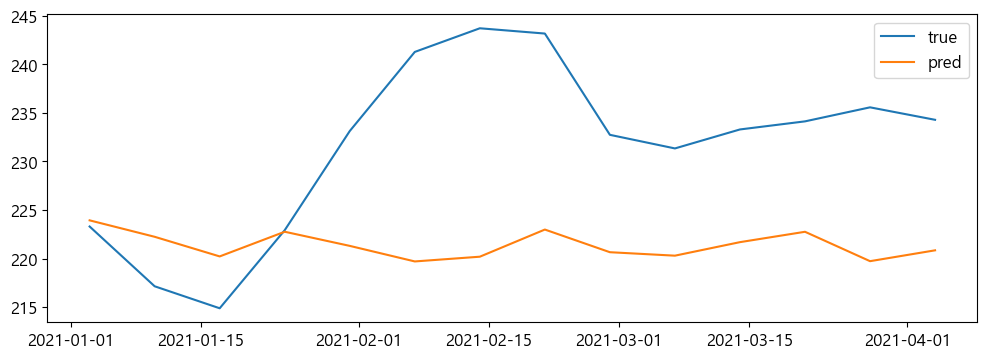

In [ ]:


from sklearn.metrics import r2_score
import numpy as np

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

tail1d = down_tail.values.ravel()
r2 = r2_score(tail1d, pred1)
mape = MAPE(tail1d, pred1)

print('{}: R2 {:.3f}, MAPE {:.3f}'.format('예측성능', r2, mape))

fig, ax = plt.subplots(1,1,figsize=(12, 4))
ax.plot(down_tail, label='true')
ax.plot(pred, label='pred')
plt.legend()
plt.show()



In [20]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(down_head, order=(3, 1, 2), seasonal_order=(1, 0, 1, 7))
fitted = model1.fit()
resid = fitted.resid
pred1 = fitted.forecast(14)

print(fitted.summary())

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.537
Date:                           Thu, 21 Aug 2025   AIC                           1557.074
Time:                                   22:27:11   BIC                           1586.678
Sample:                               04-05-2015   HQIC                          1568.923
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1309      0.094      1.395      0.163      -0.053       0.315
ar.L2          0.9900      0.056     17.837

c:\Users\krkim1\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


예측성능: R2 0.139, MAPE 2.537


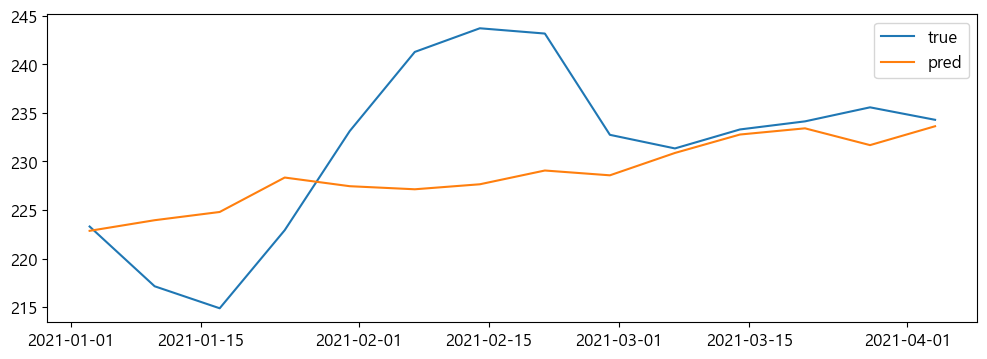

In [22]:
tail1d = down_tail.values.ravel()
r2 = r2_score(tail1d, pred1)
mape = MAPE(tail1d, pred1)

print('{}: R2 {:.3f}, MAPE {:.3f}'.format('예측성능', r2, mape))

fig, ax = plt.subplots(1,1,figsize=(12, 4))
ax.plot(down_tail, label='true')
ax.plot(pred1, label='pred')
plt.legend()
plt.show()